In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

import pyOpenLPT as lpt
lpt.PythonStreamRedirector()

### Load camera parameters and images

In [2]:
ncam = 2
bit_depth = 16

# load cam 
cam = []
intensity_max = []
useid_list = []
for i in range(ncam):
    file = '../../test/inputs/test_BubbleRefImg/cam' + str(i+1) + '.txt'
    cam.append(lpt.math.Camera(file))
    intensity_max.append(2**bit_depth-1)
    useid_list.append(i)
cam_list = lpt.math.CamList(cam, intensity_max, useid_list)
print(cam_list.to_dict())

# load image path
imgio_list = []
folder = '../../test/inputs/test_BubbleRefImg/'
for i in range(ncam):
    file = 'cam' + str(i+1) + 'ImageNames.txt'
    imgio_list.append(lpt.math.ImageIO(folder, file))
    
# load bubble image
img_list = []
img_np_list = []
for i in range(ncam):
    img = imgio_list[i].loadImg(0)
    # invert image
    for i in range(img.getDimRow() * img.getDimCol()):
        img[i] = (2**16-1) - img[i]
    img_np = lpt.math.matrix_to_numpy(img)
    img_list.append(img)
    img_np_list.append(img_np)


{'cam_list': [<pyOpenLPT.math.Camera object at 0x00000264FA6AF4B0>, <pyOpenLPT.math.Camera object at 0x00000264FA6AF5B0>], 'intensity_max': [65535, 65535], 'useid_list': [0, 1]}


### Find 2D bubbles in each camera

cam 1 found 43 bubbles
cam 2 found 49 bubbles


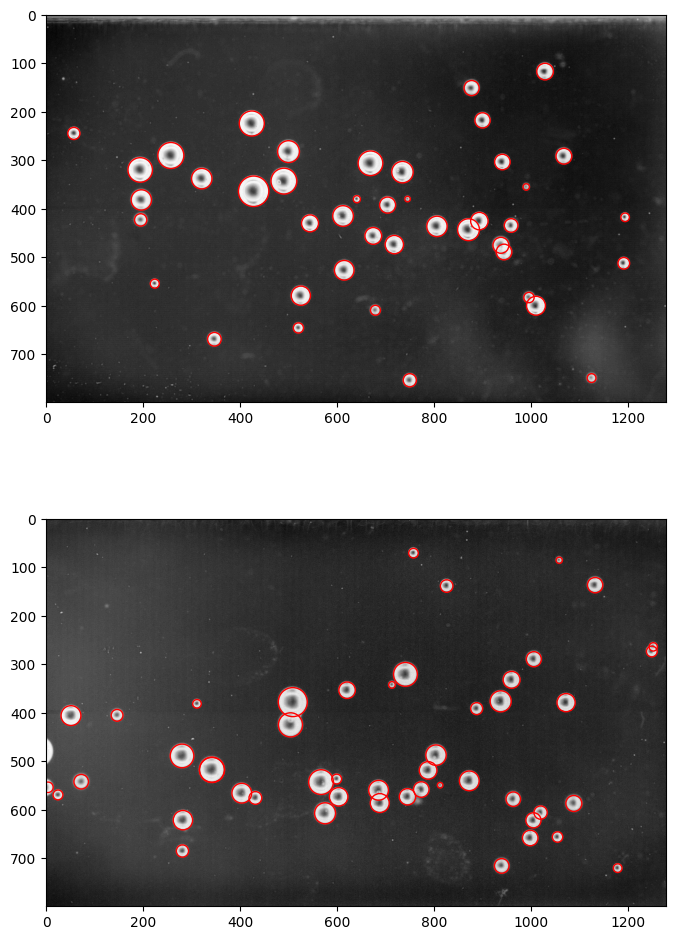

In [3]:
# define bubble property: [rmin,rmax,sensitivity]
bubble_property = [5, 50, 0.85]

bb2d_list_all = []
for i in range(ncam):
    bb2d_list = lpt.object.ObjectFinder2D().findBubble2D(img_list[i], bubble_property)
    bb2d_list_all.append(bb2d_list)
    print(f'cam {i+1} found {len(bb2d_list)} bubbles')

# plot
def draw_circle(ax, pt, r, color='red', linestyle='solid'):
    circle = plt.Circle((pt[0], pt[1]), r, linestyle=linestyle, color=color, fill=False)
    ax.add_artist(circle)
    
fig, axs = plt.subplots(ncam, 1, figsize=(8, 12))
for i in range(ncam):
    axs[i].imshow(img_np_list[i], cmap='gray')
    for bb2d in bb2d_list_all[i]:
        draw_circle(axs[i], bb2d._pt_center, bb2d._r_px, color='red')

### Bubble resize

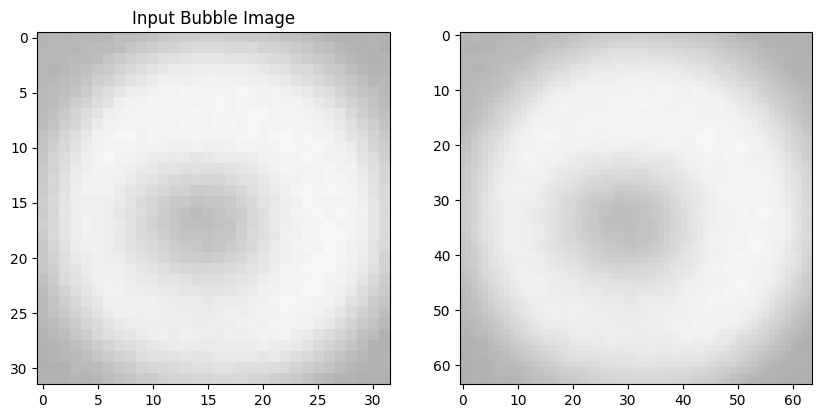

In [4]:
# test bubble resize 
cam_id = 0
bb2d = bb2d_list_all[cam_id][0]  # use the first bubble for resizing
row_min = int(np.floor(bb2d._pt_center[1] - bb2d._r_px))
row_max = int(np.ceil(bb2d._pt_center[1] + bb2d._r_px))
col_min = int(np.floor(bb2d._pt_center[0] - bb2d._r_px))
col_max = int(np.ceil(bb2d._pt_center[0] + bb2d._r_px))
img_input_np = img_np_list[cam_id][row_min:row_max, col_min:col_max].copy() 
img_input = lpt.math.Image(lpt.math.numpy_to_matrix(img_input_np))

bb_resize = lpt.object.BubbleResize()
img_output = bb_resize.ResizeBubble(img_input, 64, 2**bit_depth-1)
img_output_np = lpt.math.matrix_to_numpy(img_output)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_input_np, cmap='gray', vmin=0, vmax=2**bit_depth-1)
plt.title('Input Bubble Image')
plt.subplot(1, 2, 2)
plt.imshow(img_output_np, cmap='gray', vmin=0, vmax=2**bit_depth-1)

### Stereomatch for bubbles

In [5]:
# stereo match
sm_param = lpt.stb.SMParam()
sm_param.tor_2d = 3.
# sm_param.tor_3d = 2.8e-2
sm_param.tor_3d = 5.0e-2
sm_param.n_thread = 6
sm_param.check_id = 2
sm_param.check_radius = 3
sm_param.is_delete_ghost = True
sm_param.is_update_inner_var = True

sm = lpt.stb.StereoMatch(sm_param, cam_list)
bb3d_list = sm.match(bb2d_list_all)
# sm.saveObjInfo(folder+'bb3d_list.csv', bb3d_list)
print('Number of 3D bubbles:', len(bb3d_list))


	Finish deleting gohst match: n_del = 9, n_after_del = 36.


Number of 3D bubbles: 36


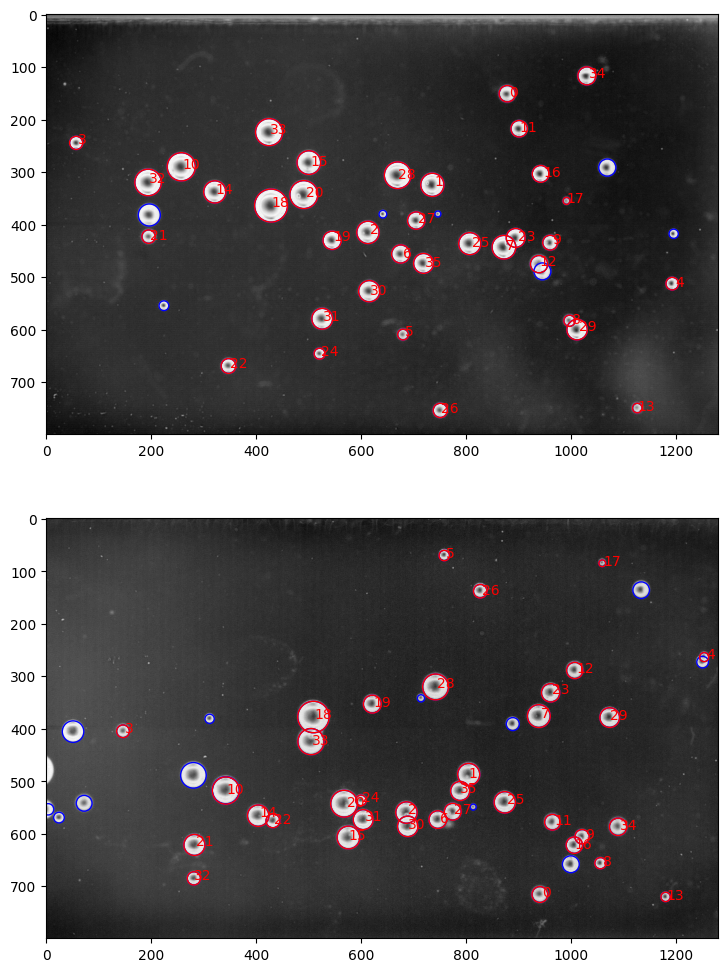

In [6]:
# plot 2d projection on each camera
fig, axs = plt.subplots(ncam, 1, figsize=(10, 12))
for cam_id in range(ncam):
    axs[cam_id].imshow(img_np_list[cam_id], cmap='gray')
    
    for bb2d in bb2d_list_all[cam_id]:
        draw_circle(axs[cam_id], bb2d._pt_center, bb2d._r_px, color='blue')
    
    for i in range(len(bb3d_list)):
        bb3d = bb3d_list[i]
        bb2d = bb3d._bb2d_list[cam_id]
        draw_circle(axs[cam_id], bb2d._pt_center, bb2d._r_px, color='red')
        axs[cam_id].text(bb2d._pt_center[0] + 5 * np.random.random(), bb2d._pt_center[1] + 5 * np.random.random(), str(i), color='red', alpha=1.0)


### Get bubble reference image

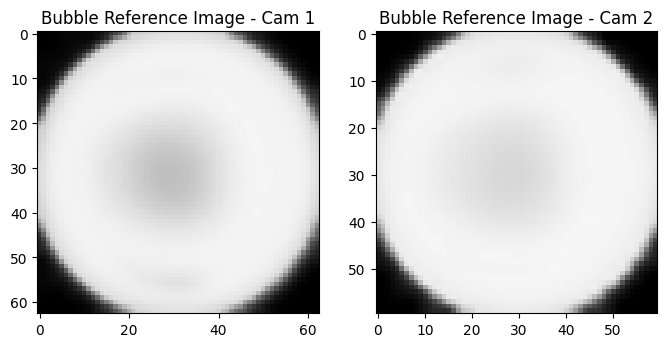

In [7]:
# get bubble reference image
bb_refimg = lpt.object.BubbleRefImg(cam_list)
is_valid, img_out = bb_refimg.GetBubbleRefImg(bb3d_list, bb2d_list_all, img_list)

fig, axs = plt.subplots(1, ncam, figsize=(8, 6))
for cam_id in range(ncam):
    img_out_np = lpt.math.matrix_to_numpy(img_out[cam_id])
    axs[cam_id].imshow(img_out_np, cmap='gray', vmin=0, vmax=2**bit_depth-1)
    axs[cam_id].set_title(f'Bubble Reference Image - Cam {cam_id + 1}')

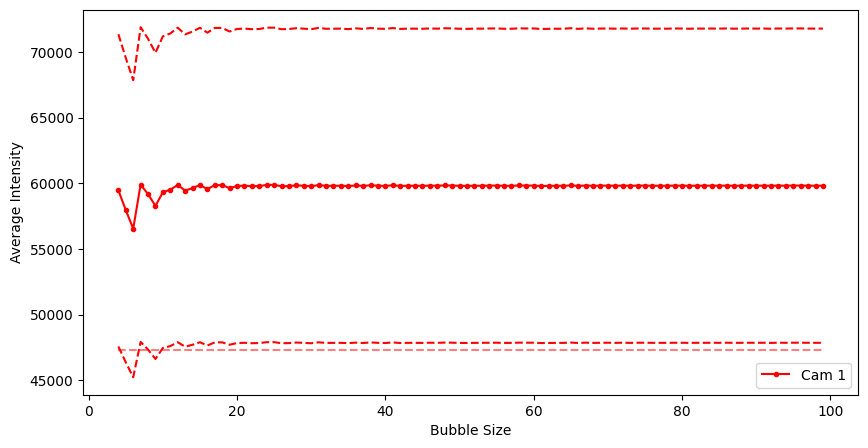

In [8]:
# test if the average intensity will change when it is resized 
size_range = np.arange(4, 100)
avg_intensity = np.zeros((len(size_range),2))

# resize ref image 
for i in range(len(size_range)):
# for i in [0]:
    img_size = size_range[i]
    bb_resize = lpt.object.BubbleResize()
    for cam_id in range(ncam):
        img_ref = bb_resize.ResizeBubble(img_out[cam_id], img_size, 2**bit_depth-1)
        img_ref_np = lpt.math.matrix_to_numpy(img_ref)
        # avg_intensity[i, cam_id] = np.mean(img_ref_np)
        n_sum = 0
        for row_id in range(img_size):
            for col_id in range(img_size):
                dist = np.sqrt((row_id - (img_size-1)/2)**2 + (col_id - (img_size-1)/2)**2)
                if dist < img_size/2.:
                    avg_intensity[i, cam_id] += img_ref_np[row_id, col_id]
                    n_sum += 1
        if n_sum > 0:
            avg_intensity[i, cam_id] /= n_sum
            
        # plt.figure(figsize=(10, 5))
        # plt.imshow(img_ref_np, cmap='gray')
        
plt.figure(figsize=(10, 5))
color_list = ['r', 'b']
# for cam_id in range(ncam):
for cam_id in [0]:
    plt.plot(size_range, avg_intensity[:, cam_id], color_list[cam_id] + '.-', label='Cam 1')
    plt.plot(size_range, avg_intensity[:, cam_id]*0.8, color_list[cam_id] + '--', label=None)
    plt.plot(size_range, avg_intensity[:, cam_id]*1.2, color_list[cam_id] + '--', label=None)
    plt.plot(size_range, np.mean(img_np_list[cam_id])*np.ones(len(size_range)), color_list[cam_id] + '--', alpha=0.5, label=None)
plt.xlabel('Bubble Size')   
plt.ylabel('Average Intensity')
plt.legend()


avg_intensity: 56762.128163265304
Image cross correlation: 0.8369701482546725


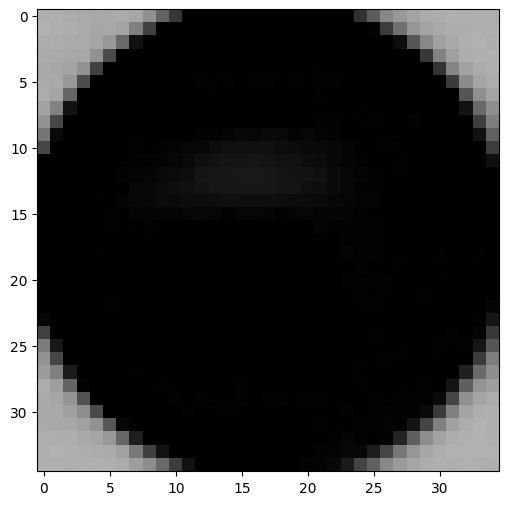

In [9]:
cam_id = 0
bb_id = 34 

# get bubble subimage
bb3d = bb3d_list[bb_id]
bb2d = bb3d._bb2d_list[cam_id]
row_min = int(np.floor(bb2d._pt_center[1] - bb2d._r_px))
row_max = int(np.ceil(bb2d._pt_center[1] + bb2d._r_px))
col_min = int(np.floor(bb2d._pt_center[0] - bb2d._r_px))
col_max = int(np.ceil(bb2d._pt_center[0] + bb2d._r_px))
# row_min = 600
# row_max = 700
# col_min = 0
# col_max = 100
img_size = min(row_max - row_min, col_max - col_min)
img_np = img_np_list[cam_id][row_min:row_min+img_size, col_min:col_min+img_size].copy()
img = lpt.math.Image(lpt.math.numpy_to_matrix(img_np))
print('avg_intensity:', np.mean(img_np))

# resize ref image 
bb_resize = lpt.object.BubbleResize()
img_ref = bb_resize.ResizeBubble(img_out[cam_id], img_np.shape[0], 2**bit_depth-1)
img_ref_np = lpt.math.matrix_to_numpy(img_ref)

# residue img
img_res_np = img_np - img_ref_np
img_res_np[img_res_np < 0] = 0  # set negative values to 0

plt.figure(figsize=(8, 6))
# plt.imshow(img_np, cmap='gray', vmin=0, vmax=2**bit_depth-1)
# plt.imshow(img_ref_np, cmap='gray', vmin=0, vmax=2**bit_depth-1)
plt.imshow(img_res_np, cmap='gray', vmin=0, vmax=2**bit_depth-1)

# calculate image cross correlation
corr = lpt.math.imgCrossCorr(img, img_ref)
print(f'Image cross correlation: {corr}')

cam 36 found 42 bubbles
Cross-correlation between original and reference images: 0.8270740132615801


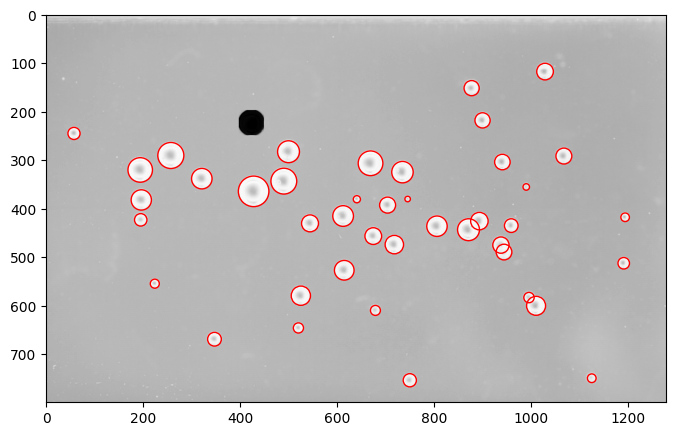

In [31]:
# test if bubble reference image is fine
img_full_np = img_np_list[cam_id].copy()
img_full_np[row_min:row_min+img_size, col_min:col_min+img_size] = img_res_np
img_full = lpt.math.Image(lpt.math.numpy_to_matrix(img_full_np))

bubble_property = [5, 50, 0.85]
bb2d_list = lpt.object.ObjectFinder2D().findBubble2D(img_full, bubble_property)
print(f'cam {i+1} found {len(bb2d_list)} bubbles')

# plot
def draw_circle(ax, pt, r, color='red', linestyle='solid'):
    circle = plt.Circle((pt[0], pt[1]), r, linestyle=linestyle, color=color, fill=False)
    ax.add_artist(circle)

fig = plt.figure(figsize=(8, 6))
plt.imshow(img_full_np, cmap='gray', vmin=0, vmax=2**bit_depth-1)
for bb2d in bb2d_list:
    draw_circle(plt.gca(), bb2d._pt_center, bb2d._r_px, color='red')
    
# Calculate cross-correlation between the original and reference images
img_np_mean = np.mean(img_np)
img_np_std = np.std(img_np)
img_ref_np_mean = np.mean(img_ref_np)
img_ref_np_std = np.std(img_ref_np)
cross_correlation = np.sum((img_np - img_np_mean) * (img_ref_np - img_ref_np_mean)) / (img_np.size * img_np_std * img_ref_np_std)
print(f'Cross-correlation between original and reference images: {cross_correlation}')

### Bubble radius projection & triangulation

Bubble 4 from cam 0: 0.27277628708949736
Bubble 4 from cam 1: 0.201886461645342
Bubble 4 projected 2d radius on cam 0: 10.486430375701625
Bubble 4 found 2d radius on cam 0: 12.05255547994486
Bubble 4 projected 2d radius on cam 1: 10.172151820033003
Bubble 4 found 2d radius on cam 1: 8.652963529316125


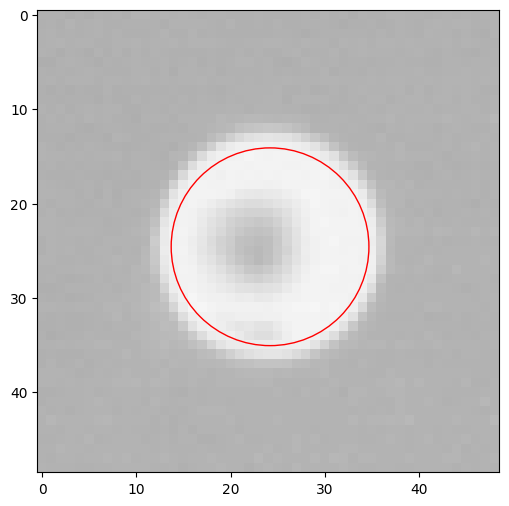

In [33]:
bb_id = 4 

# get 3d radius
r3d_list = []
for cam_id in range(ncam):
    # get 3d position in cam corrdinate
    pt3d = cam_list.cam_list[cam_id]._pinhole_param.r_mtx * bb3d_list[bb_id]._pt_center + cam_list.cam_list[cam_id]._pinhole_param.t_vec
    dist2 = pt3d[0]**2 + pt3d[1]**2 + pt3d[2]**2
    r2 = bb3d_list[bb_id]._bb2d_list[cam_id]._r_px ** 2
    f2 = cam_list.cam_list[cam_id]._pinhole_param.cam_mtx[0,0]**2
    r3d = np.sqrt(dist2 * r2 / (f2 + r2))
    r3d_list.append(r3d)
    print(f'Bubble {bb_id} from cam {cam_id}: {r3d}')
r3d = np.mean(r3d_list)

# get projected 2d radius from 3d radius
r2d_list = []
for cam_id in range(ncam):
    pt3d = cam_list.cam_list[cam_id]._pinhole_param.r_mtx * bb3d_list[bb_id]._pt_center + cam_list.cam_list[cam_id]._pinhole_param.t_vec
    dist2 = pt3d[0]**2 + pt3d[1]**2 + pt3d[2]**2
    f = cam_list.cam_list[cam_id]._pinhole_param.cam_mtx[0,0]
    r2d = r3d * f / np.sqrt(dist2 - r3d**2)
    r2d_list.append(r2d)
    print(f'Bubble {bb_id} projected 2d radius on cam {cam_id}: {r2d}')
    print(f'Bubble {bb_id} found 2d radius on cam {cam_id}: {bb3d_list[bb_id]._bb2d_list[cam_id]._r_px}')
    
cam_id = 0
# get bubble subimage
bb3d = bb3d_list[bb_id]
bb2d = bb3d._bb2d_list[cam_id]

ratio = 2
row_min = int(np.floor(bb2d._pt_center[1] - ratio*bb2d._r_px))
row_max = int(np.ceil(bb2d._pt_center[1] + ratio*bb2d._r_px))
col_min = int(np.floor(bb2d._pt_center[0] - ratio*bb2d._r_px))
col_max = int(np.ceil(bb2d._pt_center[0] + ratio*bb2d._r_px))
img_size = min(row_max - row_min, col_max - col_min)

img_np = img_np_list[cam_id][row_min:row_min+img_size, col_min:col_min+img_size].copy()
img = lpt.math.Image(lpt.math.numpy_to_matrix(img_np))

plt.figure(figsize=(8, 6))
plt.imshow(img_np, cmap='gray', vmin=0, vmax=2**bit_depth-1)
draw_circle(plt.gca(), np.array([bb2d._pt_center[0],bb2d._pt_center[1]]) - np.array([col_min, row_min]), r2d_list[cam_id], color='red')

In [70]:
r3d_list_all = []
bb_id_list = []

for bb_id in range(len(bb3d_list)):
# for bb_id in [32]:
    # get 3d radius
    r3d_list = []
    for cam_id in range(ncam):
        # get 3d position in cam corrdinate
        pt3d = cam_list.cam_list[cam_id]._pinhole_param.r_mtx * bb3d_list[bb_id]._pt_center + cam_list.cam_list[cam_id]._pinhole_param.t_vec
        dist2 = pt3d[0]**2 + pt3d[1]**2 + pt3d[2]**2
        r2 = bb3d_list[bb_id]._bb2d_list[cam_id]._r_px ** 2
        f2 = cam_list.cam_list[cam_id]._pinhole_param.cam_mtx[0,0]**2
        r3d = np.sqrt(dist2 * r2 / (f2 + r2))
        r3d_list.append(r3d)
        # print(f'Bubble {bb_id} from cam {cam_id}: {r3d}')
    r3d = np.mean(r3d_list)
    r3d_list_all.append(r3d)
    
    for cam_id in range(ncam):
        r3d_diff = np.abs(r3d_list[cam_id] - r3d)
        if r3d_diff > 0.05 * r3d or r3d_diff > sm_param.tor_3d:
            bb_id_list.append(bb_id)
            break
        
bb_id_list
# r3d_list


[4, 21, 32]

Bubble 32 3d radius: 0.43142080566164626
Bubble 32 projected 2d radius on cam 0: 19.203492244060627
Bubble 32 found 2d radius on cam 0: 25.33762217433198
Bubble 32 projected 2d radius on cam 1: 18.554904674494697
Bubble 32 found 2d radius on cam 1: 12.627952136264401


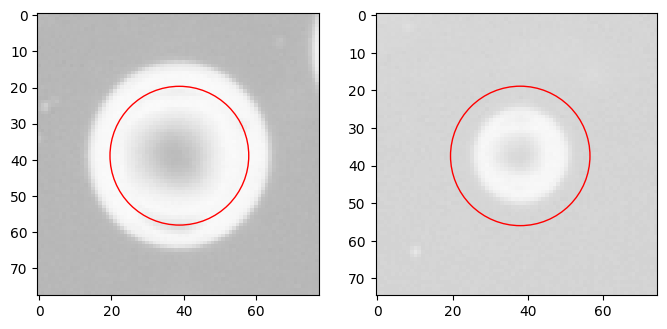

In [67]:
# plot 2d projection on each cam 
bb_id = 32
bb3d = bb3d_list[bb_id]
r3d = r3d_list_all[bb_id]
print(f'Bubble {bb_id} 3d radius: {r3d}')

fig, axs = plt.subplots(1, ncam, figsize=(8, 6))
for cam_id in range(ncam):
    bb2d = bb3d._bb2d_list[cam_id]

    pt3d = cam_list.cam_list[cam_id]._pinhole_param.r_mtx * bb3d._pt_center + cam_list.cam_list[cam_id]._pinhole_param.t_vec
    dist2 = pt3d[0]**2 + pt3d[1]**2 + pt3d[2]**2
    f = cam_list.cam_list[cam_id]._pinhole_param.cam_mtx[0,0]
    r2d = r3d * f / np.sqrt(dist2 - r3d**2)
    
    ratio = 2
    row_min = int(np.floor(bb2d._pt_center[1] - ratio*r2d))
    row_max = int(np.ceil(bb2d._pt_center[1] + ratio*r2d))
    col_min = int(np.floor(bb2d._pt_center[0] - ratio*r2d))
    col_max = int(np.ceil(bb2d._pt_center[0] + ratio*r2d))
    img_size = min(row_max - row_min, col_max - col_min)

    img_np = img_np_list[cam_id][row_min:row_min+img_size, col_min:col_min+img_size].copy()
    img = lpt.math.Image(lpt.math.numpy_to_matrix(img_np))

    axs[cam_id].imshow(img_np, cmap='gray', vmin=0, vmax=2**bit_depth-1)
    draw_circle(axs[cam_id], np.array([bb2d._pt_center[0],bb2d._pt_center[1]]) - np.array([col_min, row_min]), r2d, color='red')
    
    print(f'Bubble {bb_id} projected 2d radius on cam {cam_id}: {r2d}')
    print(f'Bubble {bb_id} found 2d radius on cam {cam_id}: {bb2d._r_px}')